## Case study

- Author: Alejandro Notario
- Date: 2019-11-07

## Steps:

- Data clean up
- Feature engineering
- Modelling
- Evaluation

__Required libraries__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

## Data clean up

- Exploring data
- Setting up the target
- Imputation
- Handling ouliers. Percentiles. Dropping

__Load the dataframe__

In [2]:
df=pd.read_csv('casestudy_data.csv', sep =',', low_memory=False)

__Exploring__

In [3]:
#dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
policy_desc                   678013 non-null int64
claim_count                   678013 non-null int64
cat_areacode                  678013 non-null object
num_vehicleAge                678013 non-null int64
num_noClaimDiscountPercent    678013 non-null int64
cat_carBrand                  678013 non-null object
num_populationDensitykmsq     678013 non-null int64
cat_Region                    678013 non-null object
ord_vehicleHP                 678013 non-null int64
num_exposure                  678013 non-null object
cat_fuelType                  677991 non-null object
num_driverAge                 677999 non-null object
dtypes: int64(6), object(6)
memory usage: 62.1+ MB


__Target__

Exploring the target to decide how is going to be worked

In [4]:
df.claim_count.value_counts()

0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
16         1
9          1
8          1
6          1
Name: claim_count, dtype: int64

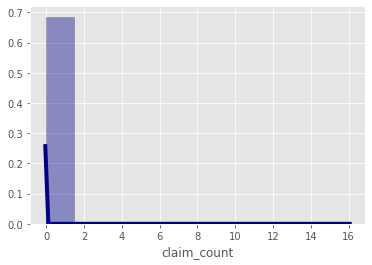

In [5]:
sns.distplot(df['claim_count'],  kde=True, 
             bins=int(11), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

__The target has their main values between 0 an 1 claim so it is going to be set up 3 categories:__

- 0 -> 0 claims
- 1 -> 1 claim
- 2 -> >= 2 claims

__Recoding__

In [6]:
def recode(row):
    if row['claim_count'] >= 2: 
        val = 2
    else:
        val=row['claim_count']
        
    return val

df['target'] = df.apply (recode, axis=1)

As it can be seen above, num_exposure, which is a numerical variable, has an object type, lets see what happens:

- Creating a new only numeric variable
- Checking the rows that they are not in the new column

In [7]:
df['num_exposure_num'] = pd.to_numeric(df['num_exposure'], errors='coerce')
#those rows with no numerical value are recoded as null, lets see several calues distributions
print(df.num_exposure_num.describe())
print(df[df['num_exposure_num'].isnull()].claim_count.value_counts())
print(df[df['num_exposure_num'].isnull()].num_exposure.value_counts())
print(df[df['num_exposure_num'].isnull()].num_exposure.count())

count    677942.000000
mean          0.528750
std           0.364441
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: num_exposure_num, dtype: float64
0    66
1     4
2     1
Name: claim_count, dtype: int64
37years    27
23years    27
10years    17
Name: num_exposure, dtype: int64
71


It seems it is either another variable or these values are from another customer cluster or whatever. To train this model, as p75 is around 1 year policy exposure and they are 71 rows out of 678013, they are going to be dropped

In [8]:
#Dropping
df = df[~df['num_exposure_num'].isnull()]

In [9]:
df.shape

(677942, 14)

__Method 2__

The main difference between this method and the method1 is this includes every customer, but it means that the predictions accuracy could be misleading because the model takes the tiem periods as a variable and in actually the prediction requieres exactly the same period to work right

New dataframe info

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677942 entries, 0 to 678012
Data columns (total 14 columns):
policy_desc                   677942 non-null int64
claim_count                   677942 non-null int64
cat_areacode                  677942 non-null object
num_vehicleAge                677942 non-null int64
num_noClaimDiscountPercent    677942 non-null int64
cat_carBrand                  677942 non-null object
num_populationDensitykmsq     677942 non-null int64
cat_Region                    677942 non-null object
ord_vehicleHP                 677942 non-null int64
num_exposure                  677942 non-null object
cat_fuelType                  677920 non-null object
num_driverAge                 677928 non-null object
target                        677942 non-null int64
num_exposure_num              677942 non-null float64
dtypes: float64(1), int64(7), object(6)
memory usage: 77.6+ MB


There are nulls at cat_fuelType and num_driverAge

- To analyze their distribution
- To decide if drop ot make an imputation

In [11]:
print("nulls: ", df.cat_fuelType.isnull().sum())
print(df.cat_fuelType.value_counts(), df.cat_fuelType.describe())
print("nulls: ", df.num_driverAge.isnull().sum())
print(df.num_driverAge.describe())

nulls:  22
Regular     345819
Diesel      332086
Electric        15
Name: cat_fuelType, dtype: int64 count      677920
unique          3
top       Regular
freq       345819
Name: cat_fuelType, dtype: object
nulls:  14
count     677928
unique        85
top           36
freq       17528
Name: num_driverAge, dtype: object


Null are going to be filled by the top value at cat_fuelType and by the median at num_driverAge

In [12]:
df.num_driverAge.isnull().sum()

14

In [13]:
#transform to numeric
df['num_driverAge_num'] = pd.to_numeric(df['num_driverAge'], errors='coerce')

There are blank rows at num_driverAge and this is a problem to work with the column data

In [14]:
df[df['num_driverAge_num'].isnull()].head()

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge,target,num_exposure_num,num_driverAge_num
258,546,1,D,0,50,B12,1489,R52,5,0.76,Regular,,1,0.76,NaN
38838,78596,0,B,1,85,B1,68,R52,6,0.09,Diesel,NaN,0,0.09,NaN
41637,84024,1,C,9,63,B2,213,R74,7,0.6,Regular,NaN,1,0.60,NaN
94288,1012310,0,A,1,50,B12,9,R21,6,0.78,Diesel,NaN,0,0.78,NaN
105969,1032478,0,C,12,68,B6,238,R54,8,1,Diesel,,0,1.00,NaN


Let's check if there are similar issues in the rest of columns

In [15]:
#it seems there are not any blanks at the others 
df.replace(r'^\s*$', np.nan, regex=True).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677942 entries, 0 to 678012
Data columns (total 15 columns):
policy_desc                   677942 non-null int64
claim_count                   677942 non-null int64
cat_areacode                  677942 non-null object
num_vehicleAge                677942 non-null int64
num_noClaimDiscountPercent    677942 non-null int64
cat_carBrand                  677942 non-null object
num_populationDensitykmsq     677942 non-null int64
cat_Region                    677942 non-null object
ord_vehicleHP                 677942 non-null int64
num_exposure                  677942 non-null object
cat_fuelType                  677920 non-null object
num_driverAge                 677904 non-null object
target                        677942 non-null int64
num_exposure_num              677942 non-null float64
num_driverAge_num             677904 non-null float64
dtypes: float64(2), int64(7), object(6)
memory usage: 82.8+ MB


Replacing nans with column median

In [16]:
df.num_driverAge_num.median()

44.0

In [17]:
df.num_driverAge_num=df.num_driverAge_num.fillna(df.num_driverAge_num.median())

Filling cat_fuelType with the column top value

In [18]:
df.cat_fuelType=df.cat_fuelType.fillna("Regular")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677942 entries, 0 to 678012
Data columns (total 15 columns):
policy_desc                   677942 non-null int64
claim_count                   677942 non-null int64
cat_areacode                  677942 non-null object
num_vehicleAge                677942 non-null int64
num_noClaimDiscountPercent    677942 non-null int64
cat_carBrand                  677942 non-null object
num_populationDensitykmsq     677942 non-null int64
cat_Region                    677942 non-null object
ord_vehicleHP                 677942 non-null int64
num_exposure                  677942 non-null object
cat_fuelType                  677942 non-null object
num_driverAge                 677928 non-null object
target                        677942 non-null int64
num_exposure_num              677942 non-null float64
num_driverAge_num             677942 non-null float64
dtypes: float64(2), int64(7), object(6)
memory usage: 82.8+ MB


Explore distributions to check otliers at numeric columns

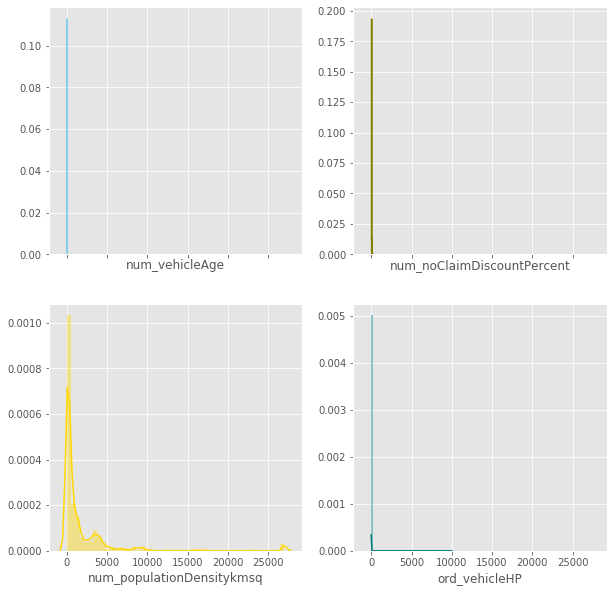

In [20]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.distplot( df["num_vehicleAge"] , color="skyblue", ax=axes[0, 0])
sns.distplot( df["num_noClaimDiscountPercent"] , color="olive", ax=axes[0, 1])
sns.distplot( df["num_populationDensitykmsq"] , color="gold", ax=axes[1, 0])
sns.distplot( df["ord_vehicleHP"] , color="teal", ax=axes[1, 1])

Tehre is something strange at ord_vehicleHP, let's see

In [21]:
df.ord_vehicleHP.value_counts()

6       148953
7       145370
5       124790
4       115321
8        46948
10       31345
9        30071
11       18351
12        8213
13        3229
15        2924
14        2347
1111        29
9999        28
999         23
Name: ord_vehicleHP, dtype: int64

ord_vehicle values of 9999, 1111, 999? suppossing they are mistakes labeling or so on, to keep the ordinal sense (the other option is one hot encoding) lets recode to 16, 17, 18 in the frequency descendent order as from 4 to 15 there are decreasing each step

In [22]:
def recode(row):
    if row['ord_vehicleHP'] == 1111:
        val = 16
    elif row['ord_vehicleHP'] == 9999:
        val = 17
    elif row['ord_vehicleHP'] == 999:
        val = 18
    else:
        val=row['ord_vehicleHP']
    return val

df['ord_vehicleHP'] = df.apply (recode, axis=1)

Maybe it would not good to drop outliers based on percentiles or so because the other variables as population density, discount, vehicle ages...are inmutable characteristics of the customers

## Feature engineering

- Scaling 
- Encoding
- New variables

__Standard scaling__

It is good practice using SVM and KNN to scale because they are algorithms that exploit distances.
There are several ways to do it. In this case it has been selected the standard scaling from the SciKit Learn library

In [23]:
#variables to transform: 
col_names = ['num_vehicleAge', 'num_noClaimDiscountPercent','num_populationDensitykmsq',
            'num_driverAge_num','num_exposure_num']
#make a copy of dataframe before scale
scaled_df = df.copy()

features = scaled_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_df[col_names] = features

Selecting/dropping columns

In [24]:
scaled_df=scaled_df[['policy_desc','cat_areacode','num_vehicleAge','num_noClaimDiscountPercent',
                    'cat_carBrand','num_populationDensitykmsq','cat_Region','ord_vehicleHP','cat_fuelType',
                    'num_exposure_num','num_driverAge_num','target']].copy()

Creating dummies. Tehere are categorical varibles and one ordinal variable which are going to be encoded as a binary variables.

In [25]:
#new dataframe with binary dummies
enc_df=scaled_df.copy()
enc_df=pd.get_dummies(enc_df, columns=['cat_areacode', 'cat_carBrand','cat_Region',
            'ord_vehicleHP','cat_fuelType'])

In [26]:
enc_df.sample(2)

,policy_desc,num_vehicleAge,num_noClaimDiscountPercent,num_populationDensitykmsq,num_exposure_num,num_driverAge_num,target,cat_areacode_A,cat_areacode_B,cat_areacode_C,...,ord_vehicleHP_12,ord_vehicleHP_13,ord_vehicleHP_14,ord_vehicleHP_15,ord_vehicleHP_16,ord_vehicleHP_17,ord_vehicleHP_18,cat_fuelType_Diesel,cat_fuelType_Electric,cat_fuelType_Regular
526159,4117337,1.404052,-0.624275,-0.439916,-0.545355,-0.247502,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
376540,3036400,-1.066734,-0.624275,-0.408085,-1.395972,0.106177,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


__Check correlation between variables__

It is necessary to know if there are string correlated features because they can inlfuence in the predictions making overfitting or another issues.
It seems there are very few hard correlations based on Pearson coeficient, so it is not going to be extracted any variable

In [27]:
#https://www.displayr.com/what-is-a-correlation-matrix/
corr = enc_df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

## Modelling

Method: It has been selected KNN algorithm 

__Nearest Neighbors Algorithm__

Documentation about this method:

- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm



__Splitting data__

In [28]:
#splittin 75%/25% train-test
training_set, test_set = train_test_split(enc_df, test_size = 0.25, random_state = 42,
                                          stratify=enc_df['target'])

In [29]:
X_train = training_set.drop('target', axis=1).values
Y_train = training_set['target'].values
X_test = test_set.drop('target', axis=1).values
Y_test = test_set['target'].values


__Tunning hyperparameters__

- K: number of neighbors based on RMSE, seleted checking results below
- Algorithm: 'auto'. will attempt to decide the most appropriate algorithm based on the values passed to fit method
- weights ('uniform'/default)
- leaf_size(30/default)
- p(2/default) Minkowski distance metric with value of p as 2 KNN classifier is going to use Euclidean Distance Metric formula
- metric('minkowski'/default)
- metric_params, n_jobs

In [30]:
%%time

#let's see accuracies from 1 to 8 neighbors
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    #Fit the model
    classifier.fit(X_train, Y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = classifier.score(X_train, Y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = classifier.score(X_test, Y_test) 


CPU times: user 5min 18s, sys: 935 ms, total: 5min 19s
Wall time: 5min 18s


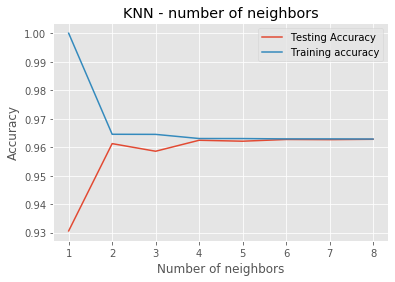

In [31]:
plt.title('KNN - number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

__Optimum testing accuracy at 4 neightbors__



In [32]:
%%time

classifier=KNeighborsClassifier(n_neighbors = 4, algorithm='auto')
classifier.fit(X_train,Y_train)

CPU times: user 6.29 s, sys: 23.9 ms, total: 6.31 s
Wall time: 6.3 s


## Evaluation

In [33]:
%%time

Y_pred = classifier.predict(X_test)

CPU times: user 8.76 s, sys: 11.7 ms, total: 8.78 s
Wall time: 8.9 s


In [34]:
test_set["Predictions"] = Y_pred

In [35]:
test_set.Predictions.value_counts()

0    167087
1      2395
2         4
Name: Predictions, dtype: int64

In [36]:
cm = confusion_matrix(Y_test,Y_pred)
print("Confusion Matrix")
print("****************")
print(cm)

Confusion Matrix
****************
[[160912     60      0]
 [  5834   2206      4]
 [   341    129      0]]


In [37]:
accuracy = float(cm.diagonal().sum())/len(Y_test)

In [38]:
print("\nAccuracy Of KNN : ", accuracy)


Accuracy Of KNN :  0.9624275751389495


__Total dataset prediction (simulating as it were a real performance)__

In [39]:
X = enc_df.drop('target', axis=1).values
Y = enc_df['target'].values

In [40]:
%%time

predictions = classifier.predict(X)

CPU times: user 32.8 s, sys: 99.5 ms, total: 32.9 s
Wall time: 33 s


In [41]:
enc_df["Predictions"] = predictions

__Simulation game__

In [42]:
policy_id=input("Please input the policy identifier: ")
policy_id=int(policy_id)
print('**************************************')
def check_results():
    """Function that returns the number of claims predicted
    and if this prediction is right
    """
    target_value=enc_df[enc_df['policy_desc']==policy_id].target.values
    prediction_value=enc_df[enc_df['policy_desc']==policy_id].Predictions.values
    
    if target_value==prediction_value:
        print("I say the claims for the policy {}".format(policy_id),
              "are goint to be in group {}".format(prediction_value), 
             "and this is a correct prediction!")
    else:
         print("I say the claims for the policy {}".format(policy_id),
              "are goint to be {}".format(prediction_value), 
             "but...oops...this is wrong, they will be in group {}".format(target_value))
    
    print ("\nGroups description: \n")
    print ("Group 0 -> 0 claims")
    print ("Group 1 -> 1 claim")
    print ("Group 2 -> 2 or more claims")
    
def main():
    check_results()

if __name__=='__main__':
    main()

Please input the policy identifier: 11
**************************************
I say the claims for the policy 11 are goint to be in group [1] and this is a correct prediction!

Groups description: 

Group 0 -> 0 claims
Group 1 -> 1 claim
Group 2 -> 2 or more claims
